In [5]:
import os
from glob import glob 
import torch
from monai.transforms import (Compose, LoadImaged, ToTensord, AddChanneld)
from monai.data import Dataset, DataLoader
from monai.utils import first
import matplotlib.pyplot as plt

In [6]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.4
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: C:\Users\deepanshu.sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.21.0
Pillow version: 10.0.1
Tensorboard version: 2.14.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cpu
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    http

In [19]:
data_dir = ("D:/brats/train/")

In [20]:
train_images = sorted(glob(os.path.join(data_dir, "images", "*.nii.gz")))
train_labels = sorted(glob(os.path.join(data_dir, "masks", "*.nii.gz")))

In [21]:
print(train_images)

['D:/brats/train/images\\BRATS_0.nii.gz', 'D:/brats/train/images\\BRATS_1.nii.gz', 'D:/brats/train/images\\BRATS_10.nii.gz', 'D:/brats/train/images\\BRATS_100.nii.gz', 'D:/brats/train/images\\BRATS_1000.nii.gz', 'D:/brats/train/images\\BRATS_1001.nii.gz', 'D:/brats/train/images\\BRATS_1002.nii.gz', 'D:/brats/train/images\\BRATS_1003.nii.gz', 'D:/brats/train/images\\BRATS_1004.nii.gz', 'D:/brats/train/images\\BRATS_1005.nii.gz', 'D:/brats/train/images\\BRATS_1006.nii.gz', 'D:/brats/train/images\\BRATS_1007.nii.gz', 'D:/brats/train/images\\BRATS_1008.nii.gz', 'D:/brats/train/images\\BRATS_1009.nii.gz', 'D:/brats/train/images\\BRATS_101.nii.gz', 'D:/brats/train/images\\BRATS_1010.nii.gz', 'D:/brats/train/images\\BRATS_1011.nii.gz', 'D:/brats/train/images\\BRATS_1012.nii.gz', 'D:/brats/train/images\\BRATS_1013.nii.gz', 'D:/brats/train/images\\BRATS_1014.nii.gz', 'D:/brats/train/images\\BRATS_1015.nii.gz', 'D:/brats/train/images\\BRATS_1016.nii.gz', 'D:/brats/train/images\\BRATS_1017.nii.gz

In [22]:
train_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]


In [23]:
train_files

[{'image': 'D:/brats/train/images\\BRATS_0.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_0.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_1.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_1.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_10.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_10.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_100.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_100.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_1000.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_1000.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_1001.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_1001.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_1002.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_1002.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_1003.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_1003.nii.gz'},
 {'image': 'D:/brats/train/images\\BRATS_1004.nii.gz',
  'label': 'D:/brats/train/masks\\BRATS_1004.nii.gz'},
 {'image': 'D:/brats/train/i

In [24]:
train_transforms = Compose(
    [
        LoadImaged(keys = ['image', 'label']),
        AddChanneld(keys = ['image', 'label']),
        ToTensord(keys = ['image', 'label']),
    ]
)

C:\Users\deepanshu.sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
C:\Users\deepanshu.sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\utils\deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
C:\Users\deepanshu.sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.transforms.util

In [25]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [26]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [27]:
# here we don't cache any data in case out of memory issue
train_ds = Dataset(data = train_files, transform = train_transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

image shape: torch.Size([4, 240, 240, 155])


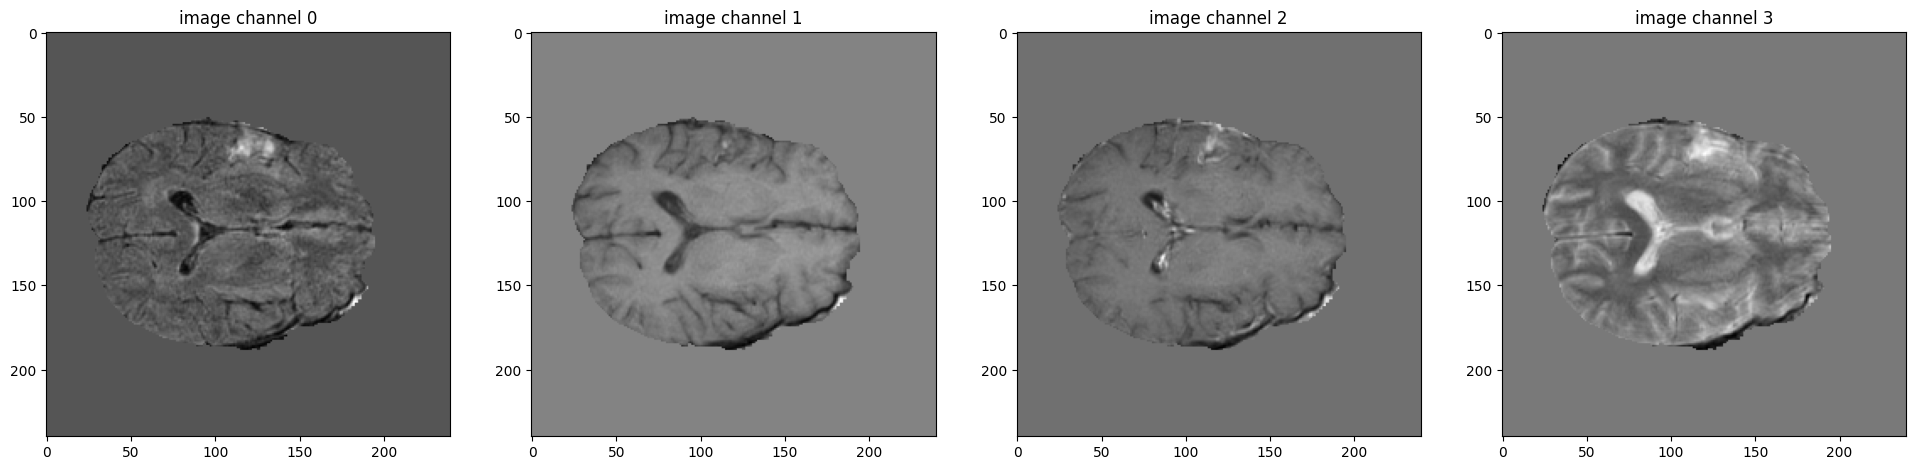

label shape: torch.Size([3, 240, 240, 155])


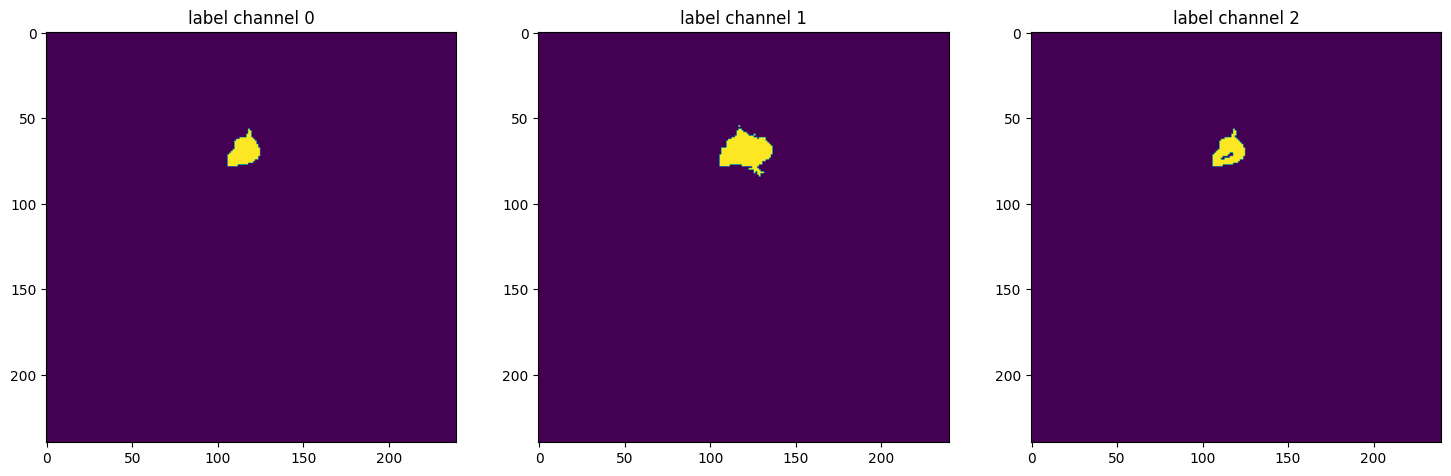

In [28]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = train_ds[45]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 70].detach().cpu())
plt.show()

In [47]:
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
)

In [48]:
VAL_AMP = True
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

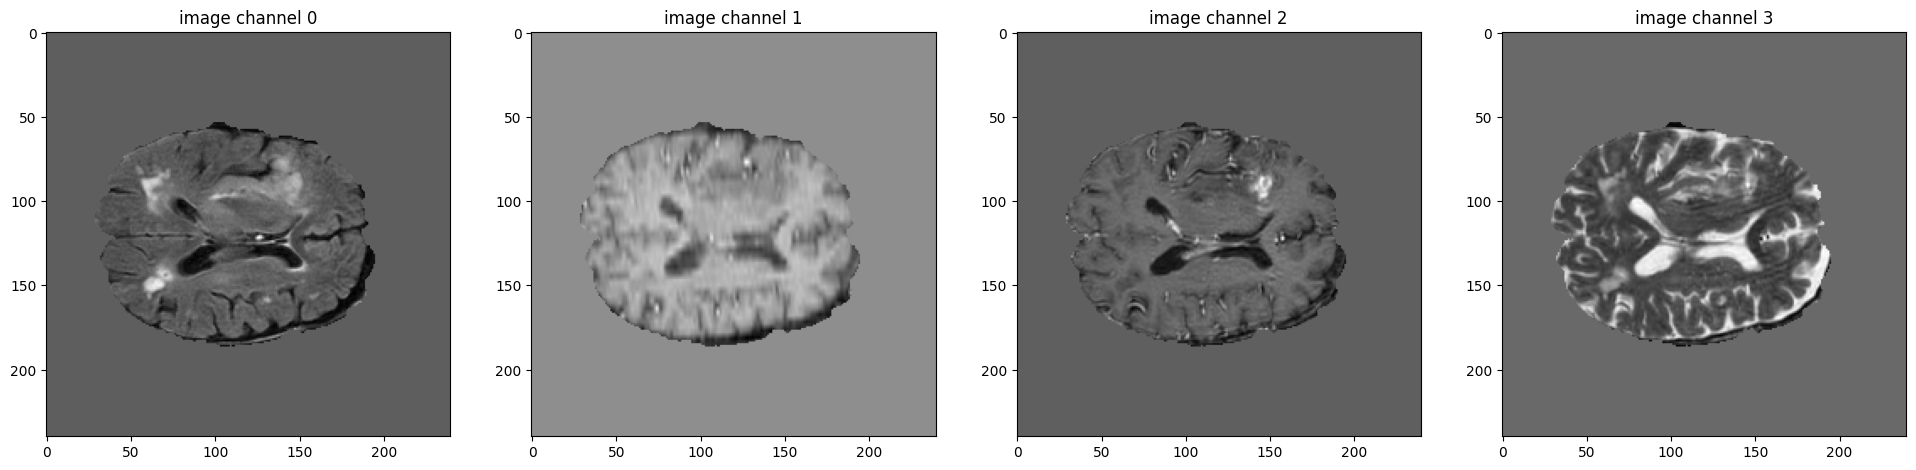

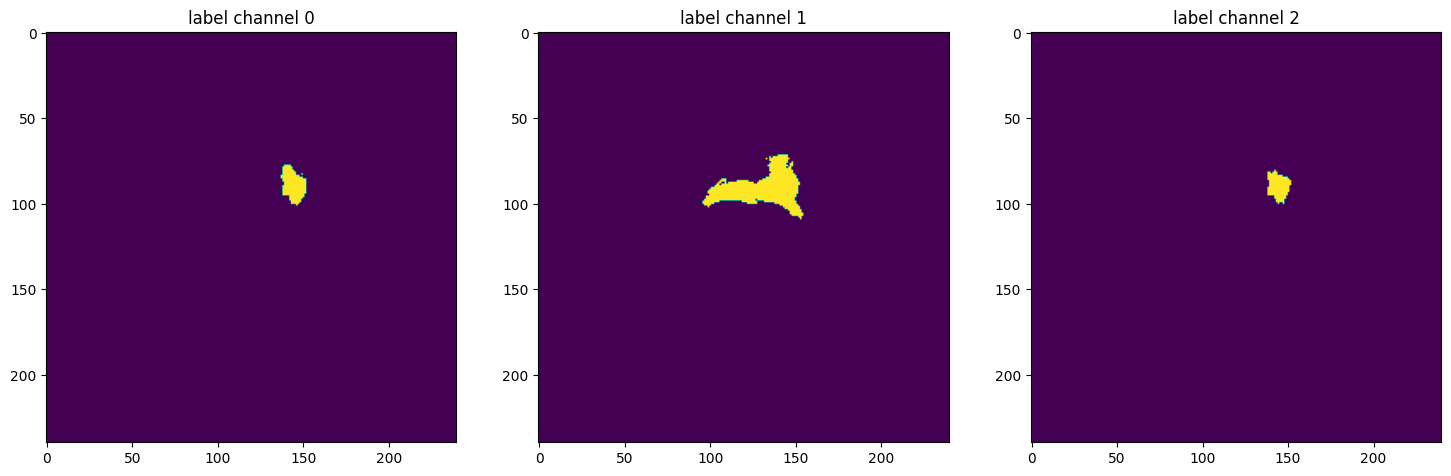

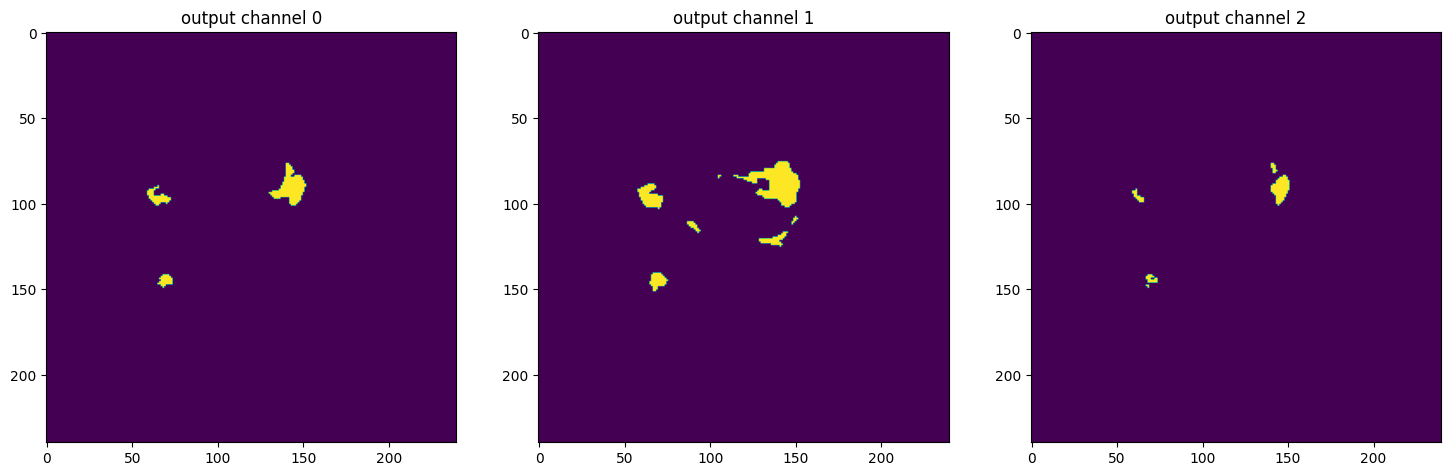

In [51]:
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
model.load_state_dict(torch.load("D:/brats_mri_segmentation/models/model.pt", map_location=torch.device('cpu')))
model.eval()

case = 45

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = train_ds[case]["image"].unsqueeze(0)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(train_ds[case]["image"][i, :, :, 85].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(train_ds[case]["label"][i, :, :, 85].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 85].detach().cpu())
    plt.show()

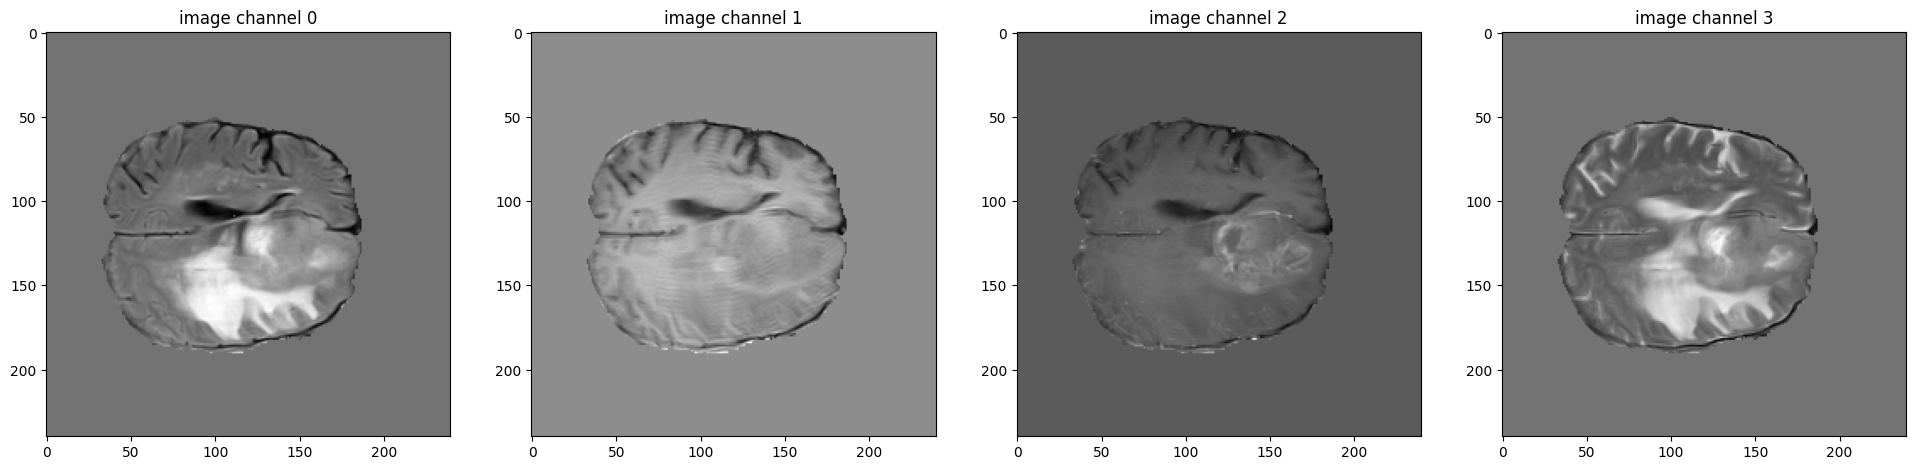

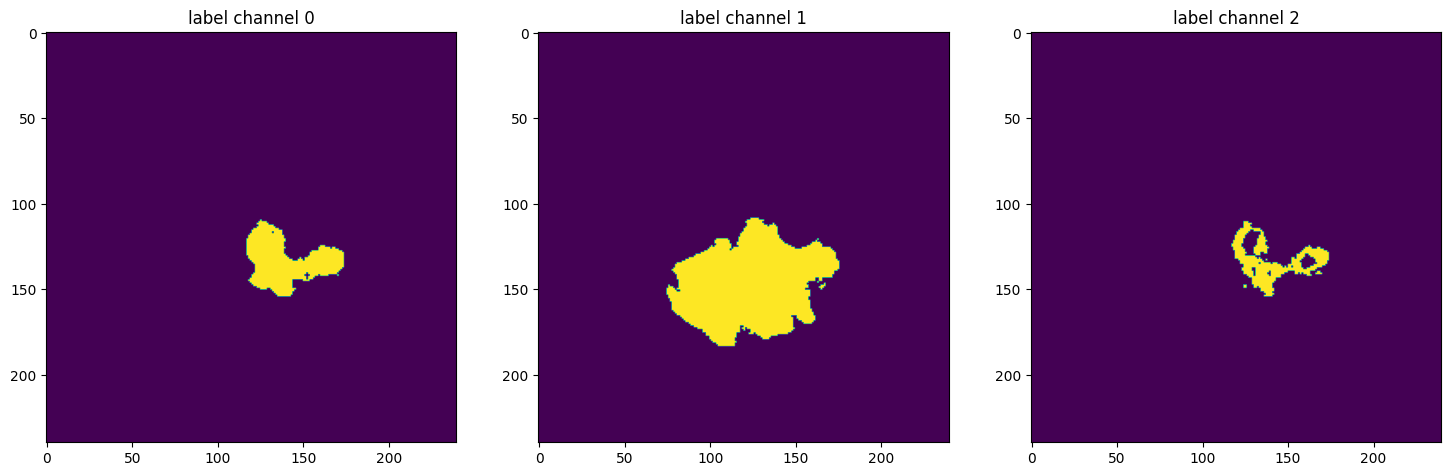

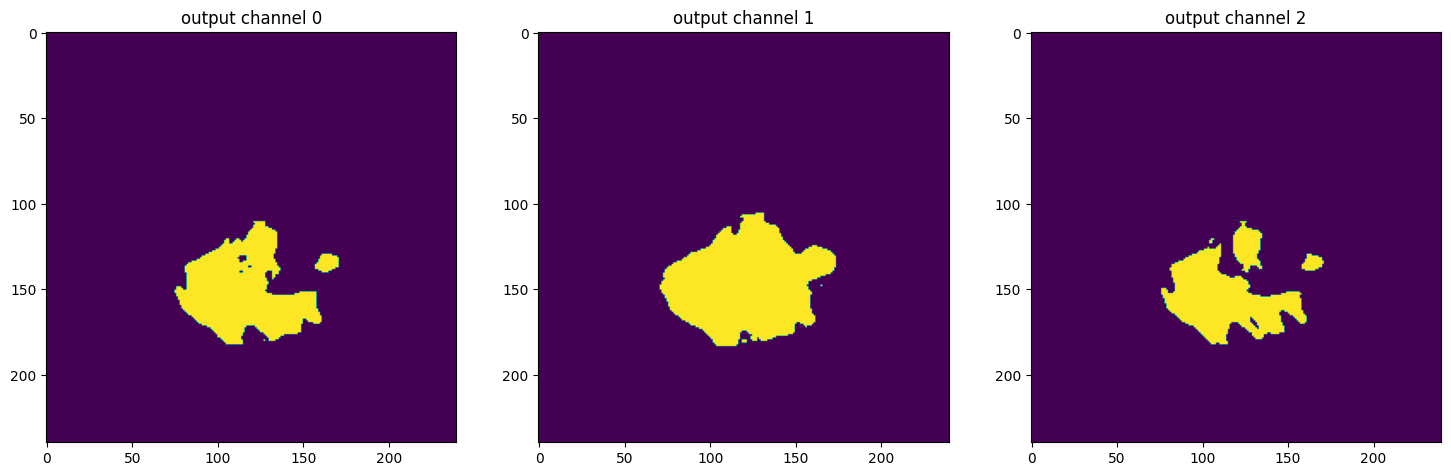

In [50]:
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
model.load_state_dict(torch.load("D:/brats_mri_segmentation/models/model.pt", map_location=torch.device('cpu')))
model.eval()

case = 180

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = train_ds[case]["image"].unsqueeze(0)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(train_ds[case]["image"][i, :, :, 85].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(train_ds[case]["label"][i, :, :, 85].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 85].detach().cpu())
    plt.show()

In [28]:
train_ds = Dataset(data = train_files, transform = train_transforms)

In [30]:
train_loader = DataLoader(train_ds, batch_size = 4)

In [33]:
test_patient = first(train_loader)

In [35]:
len(test_patient)

4

In [43]:
test_patient['image'].shape

torch.Size([4, 1, 240, 240, 155, 4])

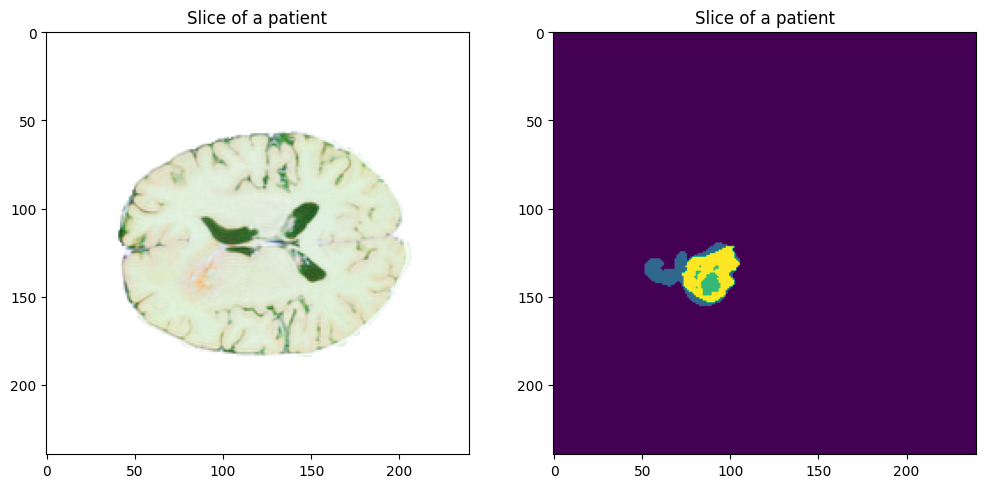

In [41]:
plt.figure('test', (12,6))
plt.subplot(1,2,1)
plt.title("Slice of a patient")
plt.imshow(test_patient['image'][0,0,:,:,85], cmap = 'gray')


plt.subplot(1,2,2)
plt.title("Slice of a patient")
plt.imshow(test_patient['label'][0,0,:,:,85])
plt.show()
